In [43]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.linalg

class Model(object):
    
    def __init__(self, tumorlabel = 'Tumor', tumorcolor = 'red', 
                 healthylabel = 'Normal', healthycolor = 'blue', 
                 immunelabel = 'Imune', immunecolor = 'black'):
        
        self.tumorColor = tumorcolor
        self.healthyColor = healthycolor
        self.immuneColor = immunecolor    
        self.tumorLabel = tumorlabel
        self.healthyLabel = healthylabel
        self.immuneLabel = immunelabel
        
        
    def initiate(self):
        self.time = np.zeros((self.healthy_0.size, int(self.steps / self.timestep)), dtype=np.float64)
        self.healthy = np.zeros((self.healthy_0.size, int(self.steps / self.timestep)), dtype=np.float64)
        self.tumor = np.zeros((self.healthy_0.size,int(self.steps / self.timestep)), dtype=np.float64)
        self.immune = np.zeros((self.healthy_0.size,int(self.steps / self.timestep)), dtype=np.float64) 
        self.control = np.zeros((self.healthy_0.size,int(self.steps / self.timestep)), dtype=np.float64)
        
        for i in range(self.healthy_0.size):
            self.healthy[i][0] = self.healthy_0[i]
            self.tumor[i][0] = self.tumor_0[i]
            self.immune[i][0] = self.immune_0[i]
            self.time[i][0] = self.time_0[i]
            
        
        
    def initialConditions(self, healthy_zero, tumor_zero, immune_zero):
        if(healthy_zero.size != tumor_zero.size or tumor_zero.size != immune_zero.size):
            raise ValueError('O Tamanho dos arrays devem ser iguais.')
                                
        self.healthy_0 = healthy_zero
        self.tumor_0 = tumor_zero
        self.immune_0 = immune_zero
        self.time_0 = np.zeros(healthy_zero.size)
        
        self.initiate()
        
    def setParameters(self, a1, a2, a3, r1, b1, c1, d1, r2, b2, c2, c3, c4, s, p, x, steps, timestep, DEMO = False, R=np.zeros((1,1))):
        self.tumorGrow = r1
        self.tumorReg = b1
        self.immuneDieToTumor = c1
        self.immuneDie = d1
        self.healthyGrow = r2
        self.healthyReg = b2
        self.tumorDieToImmune = c2
        self.tumorDieToNormal = c3
        self.normalDieToTumor = c4
        self.immuneEntry = s
        self.immuneResponse = p
        self.immuneLimit = x
        self.steps = steps
        self.timestep = timestep   
        
        self.demo = DEMO     
        
        
        ########################################
        #### Variaveis usadas no controle. #####
        ########################################
        self.MATRIX_A = np.zeros((3,3))
        self.MATRIX_A[0][0] = -r_2
        self.MATRIX_A[0][1] = -c_4/b_2
        self.MATRIX_A[1][1] = r_1 - ((c_2*s)/d_1) - c_3/b_2
        self.MATRIX_A[2][1] = ((p*s)/(d_1*x)) - ((c_1*s)/d_1)
        self.MATRIX_A[2][2] = -d_1
        
        self.MATRIX_B = np.zeros((3,1))
        self.MATRIX_B[0][0] = -a_3
        self.MATRIX_B[1][0] = -a_2
        self.MATRIX_B[2][0] = -a_1
        
        self.MATRIX_Q = np.zeros((3,3))
        self.MATRIX_Q[0][0] = 1
        self.MATRIX_Q[1][1] = 1
        self.MATRIX_Q[2][2] = 0.01
        
        self.MATRIX_R = R
        #######################################
       
        
        ############################################################
        #### Protocolos de tratamento, dados no trabalho base. #####
        ############################################################
        self.protocolos = np.zeros([5,3]);
        #Protocolo 1 - Convencional
        self.protocolos[0][0] = 60 #dose total
        self.protocolos[0][1] = 2 #dose por fração
        
        #Protocolo 2 - Hipofracionamento
        self.protocolos[1][0] = 53.61 #dose total
        self.protocolos[1][1] = 2.65 #dose por fração
        
        #Protocolo 1 - Hipofracionamento
        self.protocolos[2][0] = 49.98 #dose total
        self.protocolos[2][1] = 2.5 #dose por fração
        
        #Protocolo 1 - Hipofracionamento
        self.protocolos[3][0] = 51.85 #dose total
        self.protocolos[3][1] = 3 #dose por fração
        
        #Protocolo 1 - Convencional
        self.protocolos[4][0] = 21.98 #dose total
        self.protocolos[4][1] = 1 #dose por fração
        #############################################################
        
    def lqr(self):   
        '''
        http://www.kostasalexis.com/lqr-control.html
        '''
        #ref Bertsekas, p.151
 
        #first, try to solve the ricatti equation
        P = np.matrix(scipy.linalg.solve_continuous_are(self.MATRIX_A, self.MATRIX_B, self.MATRIX_Q, self.MATRIX_R))
     
        return P
    
    def u(self, P, X):
        X_ = np.zeros((3,1))
        X_[0][0] = 1/self.healthyReg
        X_[1][0] = 0
        X_[2][0] = self.immuneEntry/self.immuneDie
        return -scipy.linalg.inv(self.MATRIX_R)*(self.MATRIX_B.T*P*(X-X_))
        
    def survivalFraction(self, i):
        return np.exp((-self.alfa[i] * self.protocolos[0][1]) - (self.beta[i] * self.protocolos[0][1] * self.protocolos[0][1]))
        
    def fractionCellDeath_values(self, i):
        # Os paramentros radiobiologicos do modelo linear quadrático a e b, são baseados em dados clinicos e experimentos in vitro.
        a1 = 0.1
        b1 = 0.011
        a2 = a1/2
        b2 = b1/2
        a3 = a2
        b3 = b2
        
        ##############################################################################################
        ######## Parametros relacionados ao impacto da radioterapia em cada tipo de tecido. ##########
        ##############################################################################################
        a_1 = 0.2
        a_2 = 0.3
        a_3 = 0.1
        ##############################################################################################
        ##############################################################################################
        
        self.a = np.array([a_1, a_2,a_3])
        self.alfa = np.array([a1, a2, a3])
        self.beta = np.array([b1, b2, b3])
        self.gama = 1
        
        if(self.demo):
            
            retorno = {
                1: np.array([0.4082, 0.2320, 0.2320]), #I - Convencional
                2: np.array([0.5207, 0.3084, 0.3084]), #II - Hipofracionamento
                3: np.array([0.4961, 0.2909, 0.2909]), #III - Hipofracionamento
                4: np.array([0.549, 0.329, 0.329]),    #IV - Hipofracionamento
                5: np.array([0.2131, 0.1140, 0.1140])  #V - Convencional
            }[i]
        else:
            retorno = np.array([1.0,1.0,1.0])
            for i in range(3):
                retorno[i] = self.a[i] * (retorno[i] - self.survivalFraction(i))
            
            
        return retorno;
        
    def function_xyz(self, N, T, I, Bu):
        x = float(self.healthyGrow * N * (1 - self.healthyReg * N) - (self.normalDieToTumor * T * N) + Bu[0])
        y = float(self.tumorGrow * T * (1 - self.tumorReg * T) - self.tumorDieToImmune * I * T - (self.tumorDieToNormal * T * N) + Bu[1])
        z = float(self.immuneEntry + ((self.immuneResponse * I * T)/(self.immuneLimit + T)) - self.immuneDieToTumor * I * T - (self.immuneDie * I) + Bu[2])
        return np.array([x, y, z])
    
        
    def process(self, with_treatment = False, with_control = False, plot1=False, plot2=False):
        self.withControl = with_control
        
        if(with_control):
            P = self.lqr()
        
        var_for = 1;
        
        if(with_treatment):
            var_for = 5
            
        for j in range(var_for):
            days_application = 0
            rest_days = 0
            applied_dose = 0
        
            steps_k = int(self.steps / self.timestep)
            day_ = int(steps_k/self.steps)
            
            count = 0
            
            if(with_treatment):
                self.fractionDeath = self.fractionCellDeath_values(j+1)
            
            for k in range(0, steps_k - 1):
                if(with_treatment and k % day_ == 0):
                    count += 1
                    
                    if(days_application < 5 and applied_dose < self.protocolos[j][0]):
                        for i in range(self.healthy_0.size):
                            self.healthy[i][k] = (1 - self.fractionDeath[1])*self.healthy[i][k]
                            self.tumor[i][k] = (1 - self.fractionDeath[0])*self.tumor[i][k]
                            self.immune[i][k] = (1 - self.fractionDeath[2])*self.immune[i][k]
                
                        days_application+=1
                        rest_days = 0
                        applied_dose += self.protocolos[j][1]
                    
                    else:
                        rest_days+=1
                        if(rest_days == 2):
                            days_application = 0
                     
                X = np.zeros((3,1))
                for i in range(self.healthy_0.size):                  
                    
                    if(with_control):
                        X[0][0] = self.healthy[i][k]
                        X[1][0] = self.tumor[i][k]
                        X[2][0] = self.immune[i][k]
                        u = self.u(P, X)
                    else:
                        u = 0
                    
                    Bu = self.MATRIX_B * u
                    self.control[i][k] = u
                    self.rungeKutta4Method_step(i, k, Bu)
                    
            if(plot1):
                self.plot()
                
            if(plot2):
                self.plot2()
                    
                
            
            
                
                
                    
        
    def rungeKutta4Method_step(self, i, j, Bu):
            k1 = self.timestep * self.function_xyz(self.healthy[i][j], self.tumor[i][j], self.immune[i][j], Bu)
            k2 = self.timestep * self.function_xyz(self.healthy[i][j] + (self.timestep * k1[0])/2, self.tumor[i][j] + (self.timestep * k1[1])/2, self.immune[i][j] + (self.timestep * k1[2])/2, Bu)
            k3 = self.timestep * self.function_xyz(self.healthy[i][j] + (self.timestep * k2[0])/2, self.tumor[i][j] + (self.timestep * k2[1])/2, self.immune[i][j] + (self.timestep * k2[2])/2, Bu)
            k4 = self.timestep * self.function_xyz(self.healthy[i][j] + self.timestep * k3[0], self.tumor[i][j] + self.timestep * k3[1], self.immune[i][j] + self.timestep * k3[2], Bu)
            
            self.time[i][j + 1] = self.time[i][j] + self.timestep
            self.healthy[i][j+1] = self.healthy[i][j] + ((1/6) * (k1[0] + 2*(k2[0] + k3[0]) + k4[0]))
            self.tumor[i][j+1] = self.tumor[i][j] + ((1/6) * (k1[1] + 2*(k2[1] + k3[1]) + k4[1]))
            self.immune[i][j+1] = self.immune[i][j] + ((1/6) * (k1[2] + 2*(k2[2] + k3[2]) + k4[2]))
            
    def plot(self, size=(20, 7)):
        for i in range(self.healthy_0.size):
            fig = plt.figure()
            fig.set_size_inches(size)
            
            _2d = fig.add_subplot(121)
            _2d.set_xlabel('Tempo')
            _2d.plot(self.time[i], self.tumor[i], label=self.tumorLabel, color=self.tumorColor)
            _2d.plot(self.time[i], self.healthy[i], label = self.healthyLabel, color = self.healthyColor)
            _2d.plot(self.time[i], self.immune[i], label = self.immuneLabel, color = self.immuneColor)
            if (self.withControl):
                _2d.plot(self.time[i], self.control[i], label = 'Controle', color='Green')
            _2d.grid(True)
            _2d.legend()
            
            
            _3d = fig.add_subplot(122, projection='3d')
            _3d.plot3D(self.healthy[i], self.immune[i], self.tumor[i])
            _3d.scatter3D(self.healthy[i][0],self.immune[i][0],self.tumor[i][0], cmap='Yellow') # Ponto Inicial
            _3d.scatter3D(0,self.immuneEntry/self.immuneDie,0, cmap='Red') # Morte 1
            _3d.scatter3D(1/self.healthyReg, self.immuneEntry/self.immuneDie, 0, cmap='Green')
            _3d.set_xlabel(self.healthyLabel)
            _3d.set_ylabel(self.immuneLabel)
            _3d.set_zlabel(self.tumorLabel)
            _3d.set_xlim(0, 2)
            _3d.set_ylim(0, 2)
            _3d.set_zlim(0, 2)
            #_3d.plot(self.healthy, self.tumor, color='black')
            #_3d.grid(True)
            plt.show()
            
    def plot2(self, size=(20, 7), label=False, title = 'Dinâmica do crescimento de tumor, para diferentes valores de população inicial'):
        
            fig = plt.figure()
            fig.suptitle(title, fontsize=20)
            fig.set_size_inches(size)
            
            _2d1 = fig.add_subplot(131)
            _2d1.set_title(self.healthyLabel + ' vs Tempo')
            _2d1.set_xlabel('Tempo')
            _2d1.set_ylabel(self.healthyLabel)
            _2d1.grid(True)            
            
            _2d2 = fig.add_subplot(132)
            _2d2.set_title(self.tumorLabel + ' vs Tempo')
            _2d2.set_xlabel('Tempo')
            _2d2.set_ylabel(self.tumorLabel)
            _2d2.grid(True)            
            
            _2d3 = fig.add_subplot(133)
            _2d3.set_title(self.immuneLabel + ' vs Tempo')
            _2d3.set_xlabel('Tempo')
            _2d3.set_ylabel(self.immuneLabel)
            _2d3.grid(True)            
            
            for i in range(self.healthy_0.size):
                _2d1.plot(self.time[i], self.healthy[i], label='$ N_0 $:' + str(self.healthy_0[i]))
                _2d2.plot(self.time[i], self.tumor[i], label='$ T_0 $: ' + str(self.tumor_0[i]))
                _2d3.plot(self.time[i], self.immune[i], label='$ I_0 $: ' + str(self.immune_0[i]))
                
            if(label):
                _2d1.legend()
                _2d2.legend()
                _2d3.legend()                
                
            
            
            #_3d = fig.add_subplot(132, projection='3d')
            #_3d.plot3D(self.healthy[i], self.immune[i], self.tumor[i])
            #_3d.scatter3D(self.healthy[i][0],self.immune[i][0],self.tumor[i][0], cmap='Yellow') # Ponto Inicial
            #_3d.scatter3D(0,self.immuneEntry/self.immuneDie,0, cmap='Red') # Morte 1
            #_3d.scatter3D(1/self.healthyReg, self.immuneEntry/self.immuneDie, 0, cmap='Green')
            #_3d.set_xlabel(self.healthyLabel)
            #_3d.set_ylabel(self.immuneLabel)
            #_3d.set_zlabel(self.tumorLabel)
            #_3d.set_xlim(0, 2)
            #_3d.set_ylim(0, 2)
            #_3d.set_zlim(0, 2)
            #_3d.plot(self.healthy, self.tumor, color='black')
            #_3d.grid(True)
            plt.show()


<center>
    <h2>APLICAÇÃO DE CONTROLE CONTÍNUO POR PARTES PARA UM MODELO DE CRESCIMENTO DE TUMORES DE MAMA COM TRATAMENTO POR RADIOTERAPIA</h2>
    <h3>TANISIA DE CARLI FOLETTO</h3>
    <br/>
    <a href="http://livros01.livrosgratis.com.br/cp055589.pdf" target="_blank">download</a>
</center>



<h2><li>Modelo</li></h2>

<h1>
$$
\left \{
\begin{array}{rl}
\dot N = & r_2 N (1-b_2N)-c_4 TN \\
\dot T = & r_1 T (1-b_1T)-c_2 IT - c_3 TN \\
\dot I = & s+\dfrac{\rho I T}{\chi + T} - c_1 I T - d_1 I
\end{array}
\right .
$$
</h1>

In [44]:
#parametros usados varias vezes
a_1 = 0.2
a_2 = 0.3
a_3 = 0.1
b_1 = 1.0
b_2 = 1.0
c_1 = 1.0
c_2 = 0.5
c_3 = 1.0
c_4 = 1.0
d_1 = 0.2
r_1 = 1.483
r_2 = 1.0
s = 0.33
x = 0.3
p = 0.01

N_0 = np.array([0.9]) 
T_0 = np.array([0.25]) 
I_0 = np.array([0.15]) 

n_0 = np.linspace(0.4, 0.9, num=10)
n_0_fixo = np.array([0.9, 0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9]) 

t_0 = np.linspace(0.1, 0.9, num=10)
t_0_fixo = np.array([0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25]) 

i_0 = np.linspace(0.1, 0.9, num=10)
i_0_fixo = np.array([0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,0.15,])

In [59]:
#SIMULAÇÃO DE CRESCIMENTO DE TUMOR DE CANCER DE MAMA (SEM TRATAMENTO)
modelo = Model()
modelo.setParameters(a_1, a_2, a_3, r_1, b_1, c_1, d_1, r_2, b_2, c_2, c_3, c_4, s, p, x, 200, 1, R=R_)
modelo.initialConditions(N_0, T_0, I_0) # (N, T, I)
modelo.process()

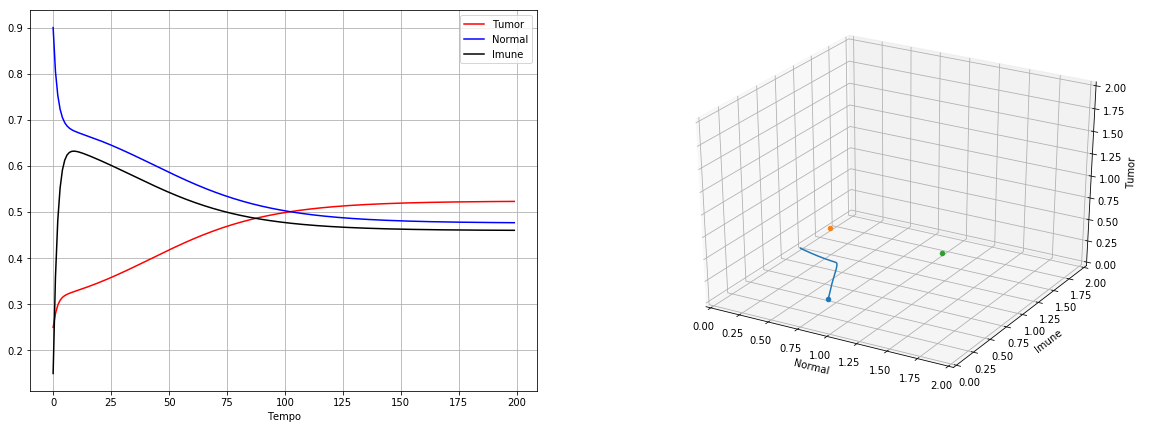

In [60]:
modelo.plot()

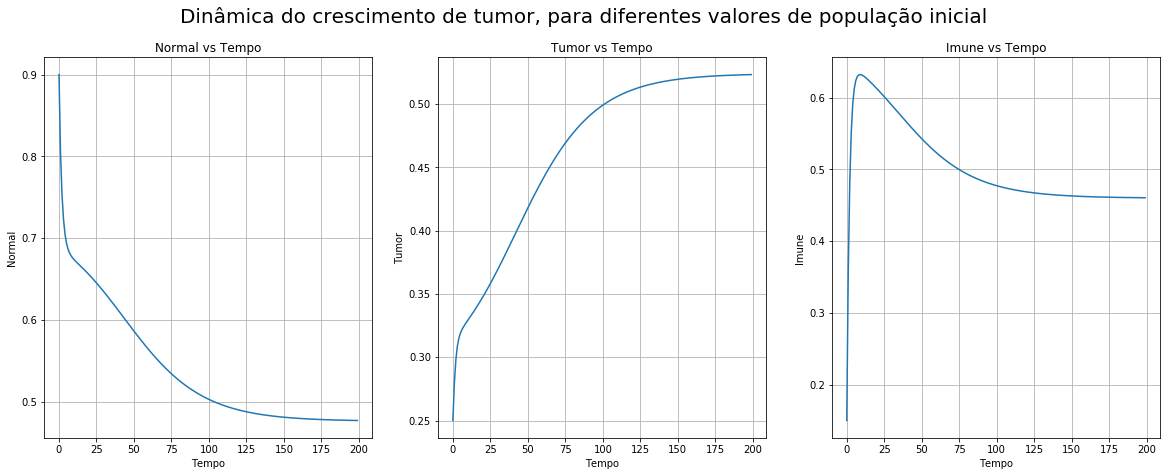

In [61]:
modelo.plot2()

In [62]:
#SIMULAÇÃO DE CRESCIMENTO DE TUMOR DE CANCER DE MAMA (SEM TRATAMENTO)
#VÁRIOS DADOS DE ORIGEM

model_normal_fixo = Model()
model_normal_fixo.setParameters(a_1, a_2, a_3, r_1, b_1, c_1, d_1, r_2, b_2, c_2, c_3, c_4, s, p, x, 200, 1)
model_normal_fixo.initialConditions(n_0_fixo, t_0, i_0) # (N, T, I)
model_normal_fixo.process()

model_tumor_fixo = Model()
model_tumor_fixo.setParameters(a_1, a_2, a_3, r_1, b_1, c_1, d_1, r_2, b_2, c_2, c_3, c_4, s, p, x, 200, 1)
model_tumor_fixo.initialConditions(n_0, t_0_fixo, i_0) # (N, T, I)
model_tumor_fixo.process()

model_imune_fixo = Model()
model_imune_fixo.setParameters(a_1, a_2, a_3, r_1, b_1, c_1, d_1, r_2, b_2, c_2, c_3, c_4, s, p, x, 200, 1)
model_imune_fixo.initialConditions(n_0, t_0, i_0_fixo) # (N, T, I)
model_imune_fixo.process()

model_2_fixo = Model()
model_2_fixo.setParameters(a_1, a_2, a_3, r_1, b_1, c_1, d_1, r_2, b_2, c_2, c_3, c_4, s, p, x, 200, 1)
model_2_fixo.initialConditions(n_0_fixo, t_0, i_0_fixo) # (N, T, I)
model_2_fixo.process()

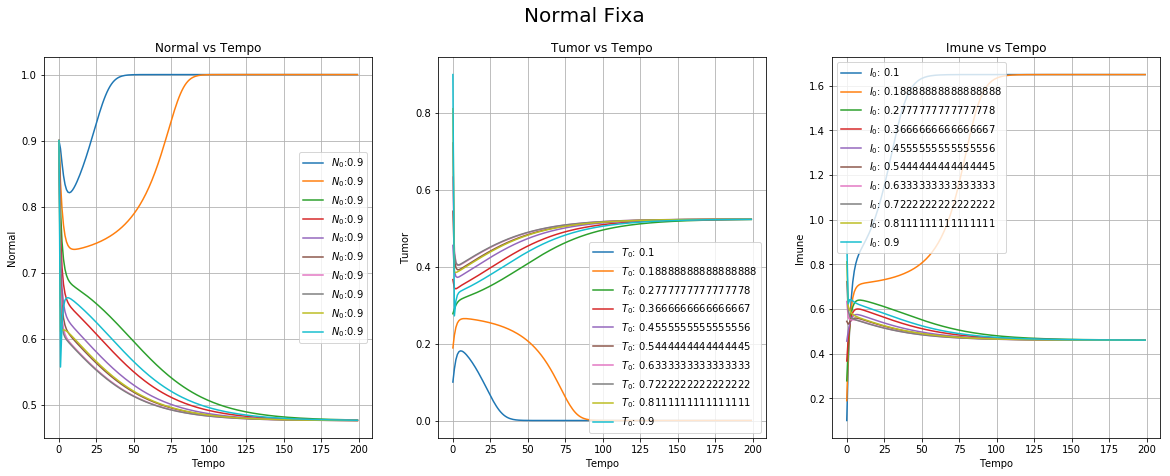

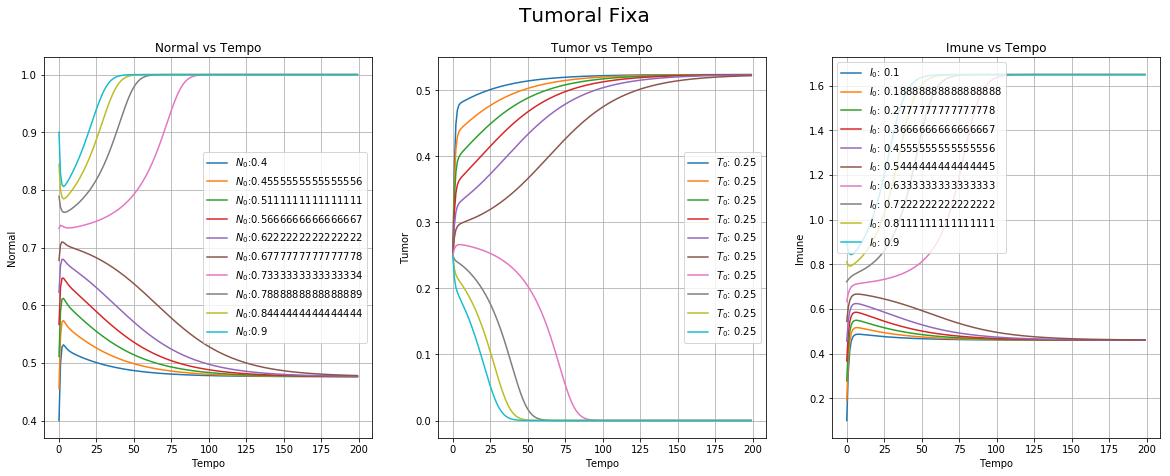

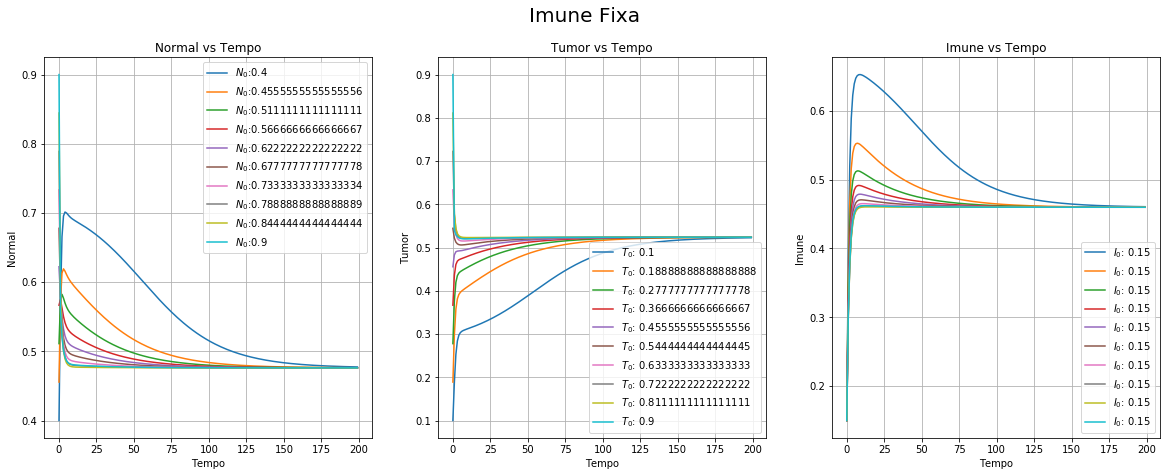

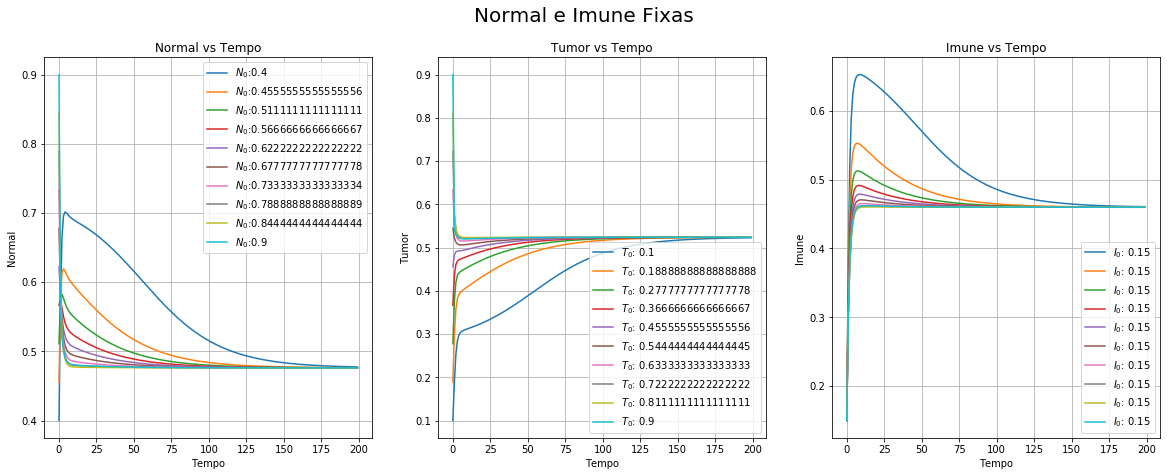

In [63]:
model_normal_fixo.plot2(title='Normal Fixa', label=True)
model_tumor_fixo.plot2(title='Tumoral Fixa',label=True)
model_imune_fixo.plot2(title='Imune Fixa',label=True)
model_imune_fixo.plot2(title='Normal e Imune Fixas',label=True)

In [33]:
#model_normal_fixo.plot()
#model_tumor_fixo.plot()
#model_imune_fixo.plot()

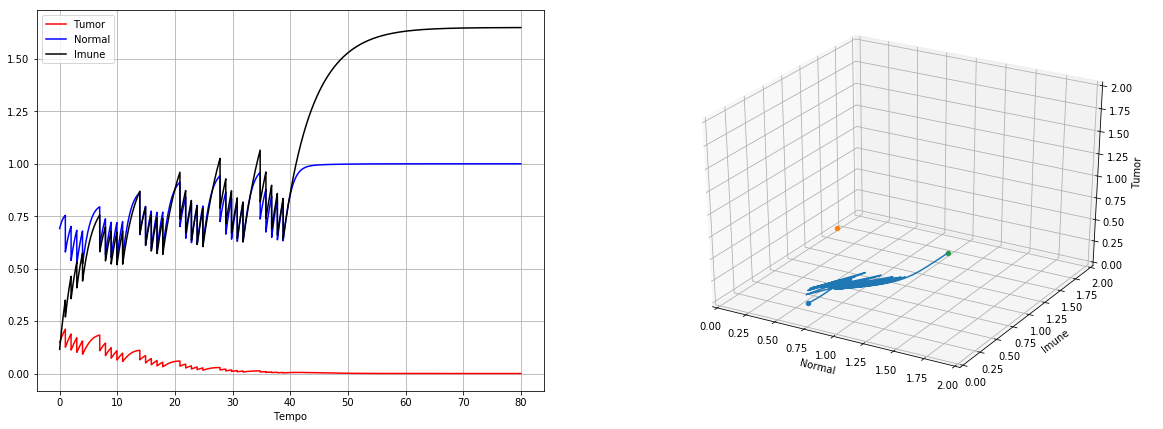

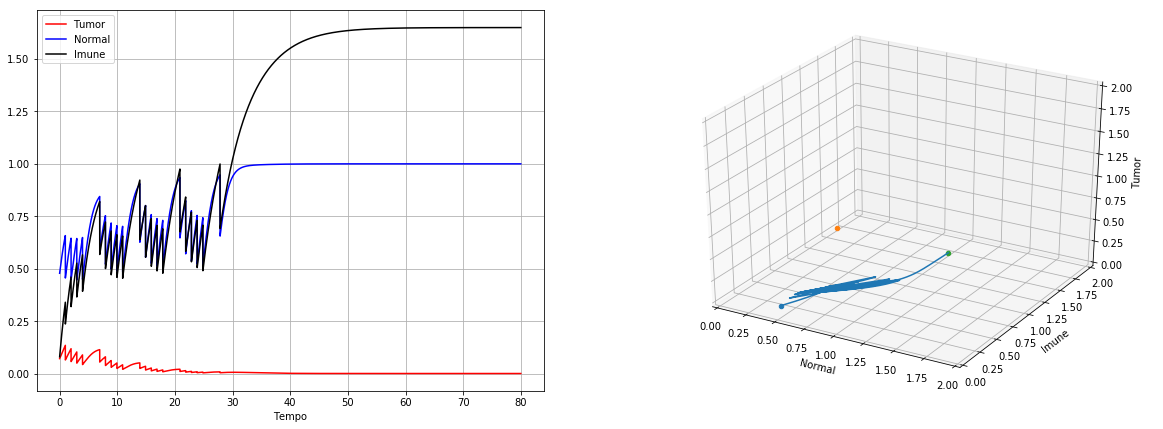

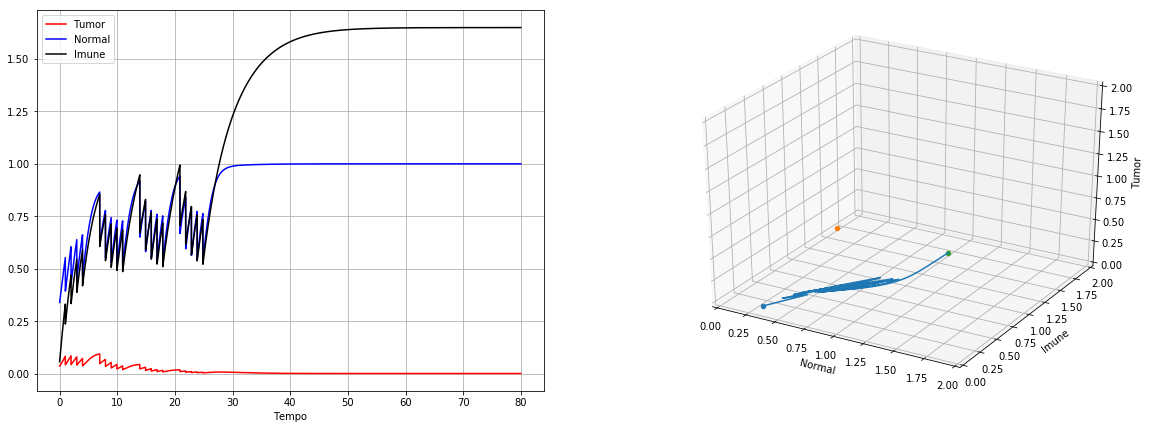

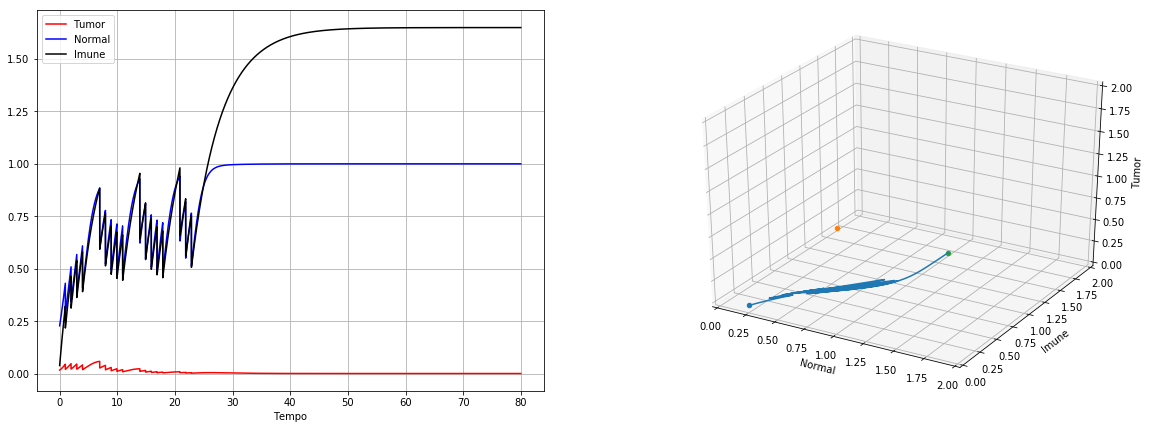

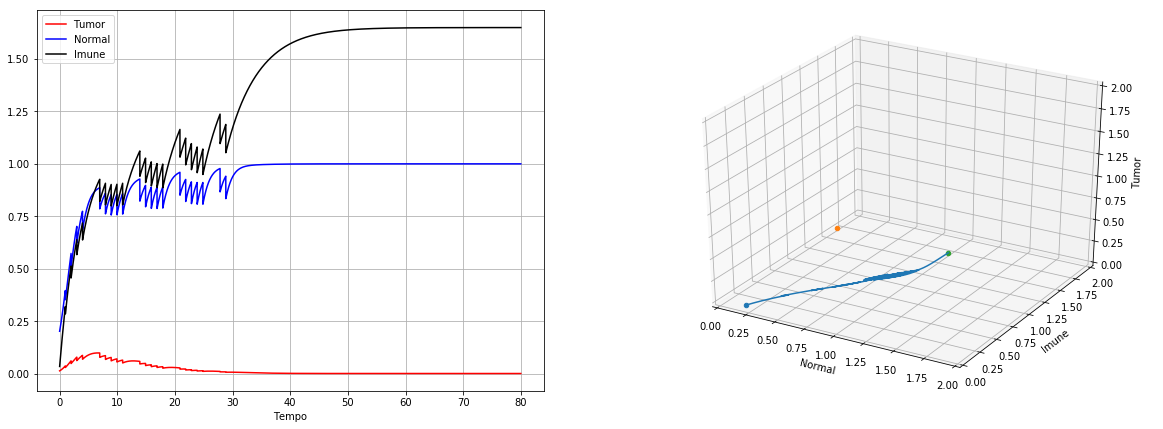

In [65]:
# analise do comportamento do modelo com o modelo linear quadratico para simular o tratamento com radioterapia
# 5 PROTOCOLOS

modelo = Model()
modelo.setParameters(a_1, a_2, a_3, r_1, b_1, c_1, d_1, r_2, b_2, c_2, c_3, c_4, s, p, x, 80, 0.007, True)
modelo.initialConditions(N_0, T_0, I_0) # (N, T, I)
modelo.process(with_treatment=True, plot1=True)

In [67]:
#SIMULAÇÃO DE CRESCIMENTO DE TUMOR DE CANCER DE MAMA COM CONTROLE (SEM TRATAMENTO)
R_ = np.zeros((1,1))
R_[0][0] = 1

modelo = Model()
modelo.setParameters(a_1, a_2, a_3, r_1, b_1, c_1, d_1, r_2, b_2, c_2, c_3, c_4, s, p, x, 200, 1, R=R_)
modelo.initialConditions(N_0, T_0, I_0) # (N, T, I)
modelo.process(with_control=True)

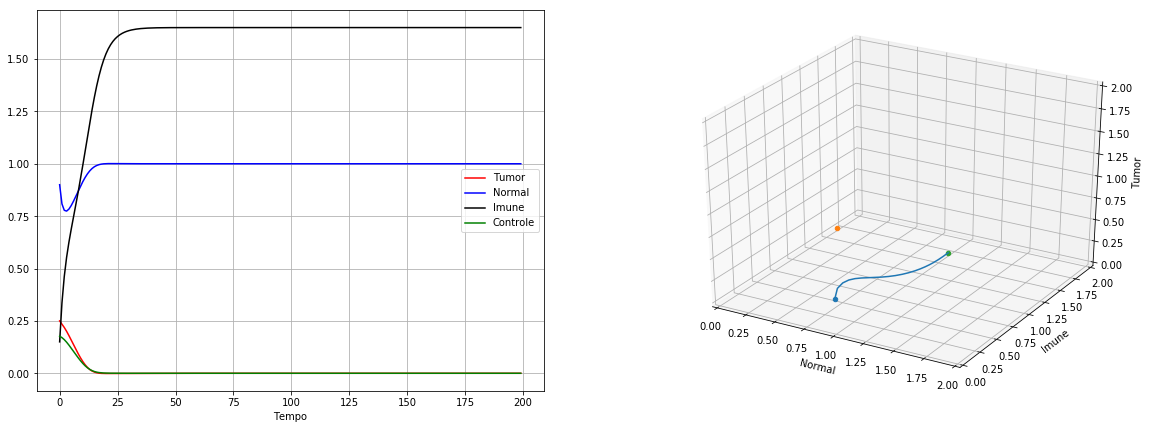

In [68]:
modelo.plot()

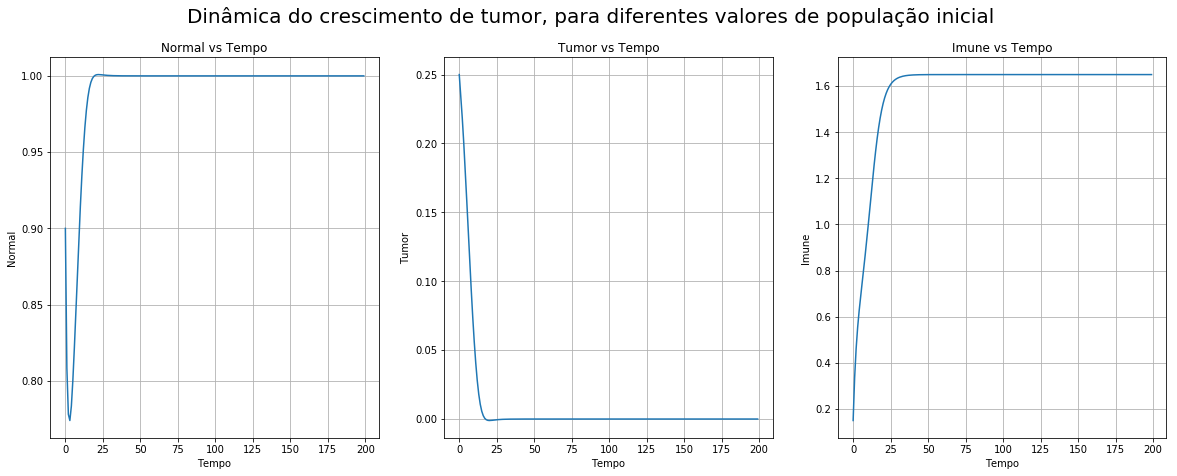

In [69]:
modelo.plot2()